# import modules

In [1]:
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input,regularizers
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,BatchNormalization,MaxPool1D
from keras.models import Model
import time

from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np
from keras.wrappers import scikit_learn

# Load Features

In [2]:
X_features=np.load('X_gabor.npy')
y=np.load('y_final.npy')

In [3]:
# X_features[0]

In [4]:
# X2_features

In [5]:
y.shape

(4704, 4)

In [6]:
y[0]

array(['1', '0', '0', '0'], dtype='<U1')

In [7]:
alphabet_set={'0': 0,'a': 1,'e': 2,'g': 3,'i': 4,'n': 5,'o': 6,'r': 7,'u': 8,'v': 9}

In [8]:
alphabet_set={value:key for key,value in alphabet_set.items()}

## One-hot Encoding

In [9]:
y=to_categorical(y,num_classes=10)

In [10]:
y.shape

(4704, 4, 10)

## split train and test

In [11]:
np.random.seed(116)
np.random.shuffle(X_features)
np.random.seed(116)
np.random.shuffle(y)
tf.random.set_seed(116)

In [12]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.2,random_state=2019)

In [13]:
X_train.shape,X_test.shape

((3763, 35, 7), (941, 35, 7))

In [14]:
y_train.shape,y_test.shape

((3763, 4, 10), (941, 4, 10))

# Models


In [49]:
NUM_CLASSES=10
BATCH_SIZE=128
EPOCHS=150
MODEL_SAVE_PATH='final_gabor_cnn.h5'

In [50]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax', name='attention')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model():
    inputs = Input(shape=(35, 7))
    x=BatchNormalization()(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(x)  #, padding = 'same'
    x = MaxPool1D()(x)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul=MaxPool1D(pool_size=10,strides=2)(attention_mul)
    output = Dense(10, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [51]:
model = attention_model()
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 35, 7)        28          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 35, 32)       256         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 17, 32)       0           conv1d_2[0][0]                   
_______________________________________________________________________________________

In [ ]:
a=time.time()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
plot_model(model,'model_final.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.2,
                  callbacks=callback_list)
b=time.time()
print("time=",(b-a))

Epoch 1/150
23/24 [===========================>..] - ETA: 0s - loss: 2.1963 - accuracy: 0.4808
Epoch 00001: val_accuracy improved from -inf to 0.50465, saving model to final_gabor_cnn.h5
24/24 [==============================] - 2s 68ms/step - loss: 2.1929 - accuracy: 0.4816 - val_loss: 2.0322 - val_accuracy: 0.5046
Epoch 2/150
23/24 [===========================>..] - ETA: 0s - loss: 1.8815 - accuracy: 0.5035
Epoch 00002: val_accuracy did not improve from 0.50465
24/24 [==============================] - 1s 33ms/step - loss: 1.8773 - accuracy: 0.5036 - val_loss: 1.6706 - val_accuracy: 0.5046
Epoch 3/150
23/24 [===========================>..] - ETA: 0s - loss: 1.5367 - accuracy: 0.5040
Epoch 00003: val_accuracy did not improve from 0.50465
24/24 [==============================] - 1s 32ms/step - loss: 1.5365 - accuracy: 0.5036 - val_loss: 1.4683 - val_accuracy: 0.5046
Epoch 4/150
23/24 [===========================>..] - ETA: 0s - loss: 1.4369 - accuracy: 0.5525
Epoch 00004: val_accuracy im

Epoch 29/150
23/24 [===========================>..] - ETA: 0s - loss: 0.8944 - accuracy: 0.6451
Epoch 00029: val_accuracy did not improve from 0.63977
24/24 [==============================] - 1s 29ms/step - loss: 0.8972 - accuracy: 0.6440 - val_loss: 0.9019 - val_accuracy: 0.6384
Epoch 30/150
23/24 [===========================>..] - ETA: 0s - loss: 0.8901 - accuracy: 0.6431
Epoch 00030: val_accuracy improved from 0.63977 to 0.64509, saving model to final_gabor_cnn.h5
24/24 [==============================] - 1s 33ms/step - loss: 0.8894 - accuracy: 0.6433 - val_loss: 0.8952 - val_accuracy: 0.6451
Epoch 31/150
23/24 [===========================>..] - ETA: 0s - loss: 0.8647 - accuracy: 0.6495
Epoch 00031: val_accuracy improved from 0.64509 to 0.65073, saving model to final_gabor_cnn.h5
24/24 [==============================] - 1s 38ms/step - loss: 0.8640 - accuracy: 0.6504 - val_loss: 0.8835 - val_accuracy: 0.6507
Epoch 32/150
23/24 [===========================>..] - ETA: 0s - loss: 0.8513 

23/24 [===========================>..] - ETA: 0s - loss: 0.5633 - accuracy: 0.7870
Epoch 00056: val_accuracy did not improve from 0.74801
24/24 [==============================] - 1s 30ms/step - loss: 0.5652 - accuracy: 0.7867 - val_loss: 0.6767 - val_accuracy: 0.7480
Epoch 57/150
23/24 [===========================>..] - ETA: 0s - loss: 0.5513 - accuracy: 0.7902
Epoch 00057: val_accuracy did not improve from 0.74801
24/24 [==============================] - 1s 30ms/step - loss: 0.5519 - accuracy: 0.7903 - val_loss: 0.6848 - val_accuracy: 0.7390
Epoch 58/150
23/24 [===========================>..] - ETA: 0s - loss: 0.5385 - accuracy: 0.79 - ETA: 0s - loss: 0.5350 - accuracy: 0.7997
Epoch 00058: val_accuracy improved from 0.74801 to 0.75664, saving model to final_gabor_cnn.h5
24/24 [==============================] - 1s 40ms/step - loss: 0.5357 - accuracy: 0.7994 - val_loss: 0.6763 - val_accuracy: 0.7566
Epoch 59/150
23/24 [===========================>..] - ETA: 0s - loss: 0.5160 - accuracy:

Epoch 84/150
23/24 [===========================>..] - ETA: 0s - loss: 0.3524 - accuracy: 0.8791
Epoch 00084: val_accuracy did not improve from 0.76826
24/24 [==============================] - 1s 30ms/step - loss: 0.3542 - accuracy: 0.8782 - val_loss: 0.6522 - val_accuracy: 0.7663
Epoch 85/150
23/24 [===========================>..] - ETA: 0s - loss: 0.3395 - accuracy: 0.8881
Epoch 00085: val_accuracy did not improve from 0.76826
24/24 [==============================] - 1s 31ms/step - loss: 0.3403 - accuracy: 0.8879 - val_loss: 0.6492 - val_accuracy: 0.7633
Epoch 86/150
23/24 [===========================>..] - ETA: 0s - loss: 0.3535 - accuracy: 0.8758
Epoch 00086: val_accuracy did not improve from 0.76826
24/24 [==============================] - 1s 30ms/step - loss: 0.3542 - accuracy: 0.8753 - val_loss: 0.6432 - val_accuracy: 0.7643
Epoch 87/150
23/24 [===========================>..] - ETA: 0s - loss: 0.3389 - accuracy: 0.8829
Epoch 00087: val_accuracy did not improve from 0.76826

Epoch

Epoch 112/150
23/24 [===========================>..] - ETA: 0s - loss: 0.3125 - accuracy: 0.8981
Epoch 00112: val_accuracy did not improve from 0.76826
24/24 [==============================] - 1s 30ms/step - loss: 0.3106 - accuracy: 0.8988 - val_loss: 0.6521 - val_accuracy: 0.7596
Epoch 113/150
23/24 [===========================>..] - ETA: 0s - loss: 0.3053 - accuracy: 0.9019
Epoch 00113: val_accuracy did not improve from 0.76826
24/24 [==============================] - 1s 30ms/step - loss: 0.3049 - accuracy: 0.9022 - val_loss: 0.6523 - val_accuracy: 0.7600
Epoch 114/150
23/24 [===========================>..] - ETA: 0s - loss: 0.3149 - accuracy: 0.8954
Epoch 00114: val_accuracy did not improve from 0.76826
24/24 [==============================] - 1s 30ms/step - loss: 0.3155 - accuracy: 0.8950 - val_loss: 0.6517 - val_accuracy: 0.7600
Epoch 115/150
23/24 [===========================>..] - ETA: 0s - loss: 0.3214 - accuracy: 0.8943
Epoch 00115: val_accuracy did not improve from 0.76826
24

## plot_curve

In [41]:
from help import plot_curve,plot_curve_with_smooth

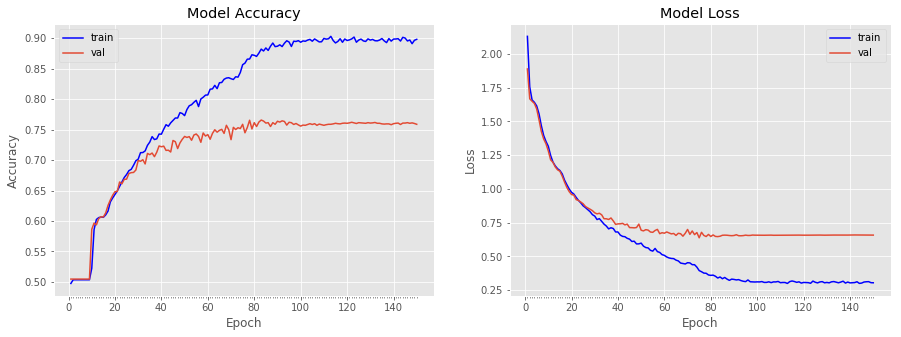

In [42]:
plot_curve(history)

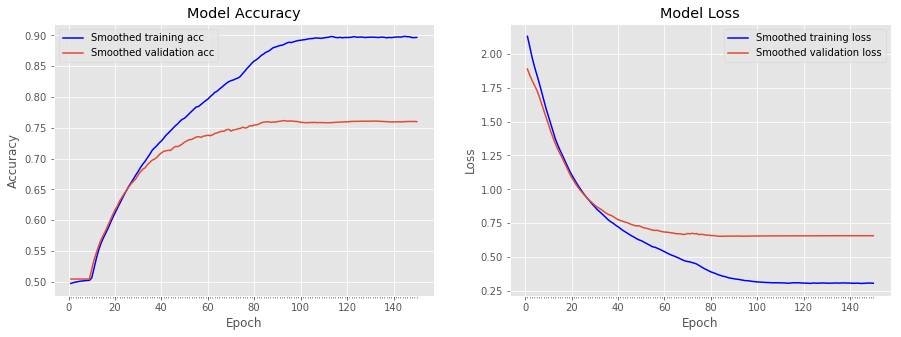

In [43]:
plot_curve_with_smooth(history)

## confusion_metrix

In [44]:
# model.load_weights(MODEL_SAVE_PATH)

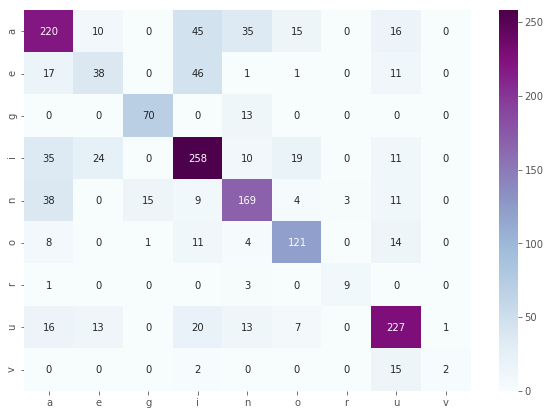

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_test,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
con_matrix=con_matrix[1:,1:]
target_names=[alphabet_set[i] for i in range(1, 10)]
import seaborn as sn

df_cm = pd.DataFrame(con_matrix,
                     index = [i for i in list(target_names)],
                     columns = [i for i in list(target_names)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.20g',cmap="BuPu")
# def plot_confusion_matrix(confusion_mat):
#     plt.figure(figsize=(12,8))
#     plt.imshow(confusion_mat)
#     plt.title('Confusion Matrix')
#     plt.colorbar()
#     labels = list(range(0,10))
#     tick_marks = np.arange(len(labels))
#     plt.xticks(tick_marks, labels)
#     plt.yticks(tick_marks, labels)
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.grid(False)
#     plt.show() 
# plot_confusion_matrix(con_matrix)

## classfication_report

In [46]:
from sklearn.metrics import classification_report


In [47]:
target_names=[alphabet_set[i] for i in range(10)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(10)),target_names=target_names))

              precision    recall  f1-score   support

           0     0.8819    0.9204    0.9007      1898
           a     0.6215    0.6145    0.6180       358
           e     0.4419    0.3220    0.3725       118
           g     0.5263    0.4000    0.4545       175
           i     0.6402    0.6935    0.6658       372
           n     0.5434    0.5090    0.5257       332
           o     0.7118    0.6836    0.6974       177
           r     0.7500    0.6429    0.6923        14
           u     0.7299    0.7542    0.7418       301
           v     0.6667    0.1053    0.1818        19

   micro avg     0.7601    0.7601    0.7601      3764
   macro avg     0.6513    0.5645    0.5851      3764
weighted avg     0.7513    0.7601    0.7536      3764



# predict test

In [48]:

temp = np.load('che1.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:u


In [33]:

temp = np.load('./gabor/person6_time1_group1_ge_4.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

FileNotFoundError: [Errno 2] No such file or directory: './gabor/person6_time1_group1_ge_4.npy'

In [72]:

temp = np.load('./gabor/person10_time1_group2_zhong_1.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:in


In [33]:
target_names=[alphabet_set[i] for i in range(10)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(10)),target_names=target_names))

              precision    recall  f1-score   support

           0     0.8932    0.9272    0.9099      1922
           a     0.6667    0.6741    0.6704       359
           e     0.4779    0.4252    0.4500       127
           g     0.5441    0.4744    0.5068       156
           i     0.7068    0.6862    0.6964       376
           n     0.5927    0.5821    0.5873       335
           o     0.7241    0.6604    0.6908       159
           r     0.7500    0.6316    0.6857        19
           u     0.7980    0.8225    0.8101       293
           v     0.0000    0.0000    0.0000        18

    accuracy                         0.7872      3764
   macro avg     0.6154    0.5884    0.6007      3764
weighted avg     0.7782    0.7872    0.7823      3764

